# Carregando dataset

In [1]:
import os
import numpy as np
import pydicom
from tqdm import tqdm # Ver processo do loop
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pickle
from keras.preprocessing.image import ImageDataGenerator
import random
from keras import backend as K
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATASET_PATH = 'Sunnybrook_Dataset/SCD_DeidentifiedImages/'
CONTOUR_PATH = 'Sunnybrook_Dataset/SCD_ManualContours/'
# PICKLE_PATH = 'Sunnybrook_Dataset/pickled_data/'
PICKLE_PATH = 'pickle/'
MODEL_PATH = 'modelo/Rede_Hibrida'

In [2]:
def converter_pixel_array_rgb(dicom):
    dicom_rgb = np.empty((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    dicom_rgb = dicom_rgb / np.max(dicom_rgb)
    return dicom_rgb

# def pre_processamento(img):
#     img_cs = exposure.equalize_adapthist(img, clip_limit=0.03)
# #     p2, p98 = np.percentile(img, (2,98))
# #     img_cs = exposure.rescale_intensity(img, in_range=(p2, p98))
#     return img_cs

def converter_mascara_binario(mask):
    im_bw = mask[:,:,0]
    im_bw = im_bw[:,:,np.newaxis]
    return im_bw

In [3]:
##### contorno_pickle = array com as coordenadas do contorno
##### mascara_pickle = mascara do ground-truth
##### scans_pickle = np.array(dicom.pixel_array)

######################################################################

scans_file = PICKLE_PATH + 'scans_pickle.pickle'
contours_file = PICKLE_PATH + 'contorno_pickle.pickle'
masks_file = PICKLE_PATH + 'mascara_pickle.pickle'
with open(scans_file, 'rb') as f:
    all_scans = pickle.load(f)
    
with open(contours_file, 'rb') as f:
    all_contours = pickle.load(f)
    
with open(masks_file, 'rb') as f:
    all_masks = pickle.load(f)


all_scans = list(map(converter_pixel_array_rgb, all_scans))

all_scans = np.array(all_scans)
# all_contours = np.array(all_contours)
all_masks = list(map(converter_mascara_binario, all_masks))
all_masks = np.array(all_masks)
# Separar em treino, teste e validacao
X_train, X_test, Y_train, Y_test = train_test_split(all_scans, all_masks, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=1)


# # converter para float
# X_train = X_train / 255
# X_val = X_val / 255
# X_test = X_test / 255

Y_train = np.where(Y_train>128, 1.0, 0.0)
Y_val = np.where(Y_val>128, 1.0, 0.0)
Y_test = np.where(Y_test>128, 1.0, 0.0)

In [4]:
len(X_train), len(X_test), len(X_val)

(563, 161, 81)

In [5]:
Y_train.shape

(563, 256, 256, 1)

In [6]:
len(X_train)

563

In [7]:
# ground_truth_ids = next(os.walk(CONTOUR_PATH))[1]    # Pegar id dos contornos

# print('Lendo os contornos')

# # Y_train = []    # Criar um array vazio para os contornos
# for n, id_ in tqdm(enumerate(ground_truth_ids), total=len(ground_truth_ids)):
#     contours = []
#     contourFolder = CONTOUR_PATH + id_ + '/contours-manual/IRCCI-expert/'
#     for cf in os.listdir(contourFolder):
#         ground_truth = []
#         mascara = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype="uint8")
#         file = open(os.path.join(contourFolder, cf), "r")
#         # Ler arquivo com as coordenadas do "ground-truth"
#         for line in file:
#             coord = line.split()
#             ground_truth.append([int(float(coord[0])),int(float(coord[1]))])
            
#         cv2.drawContours(mascara, np.array([ground_truth]), 0, (255, 255, 255), 3)
#         _, mascara = cv2.threshold(mascara,127,255,cv2.THRESH_BINARY)
#         contours.append(mascara)
# #     Y_train.append(contours)

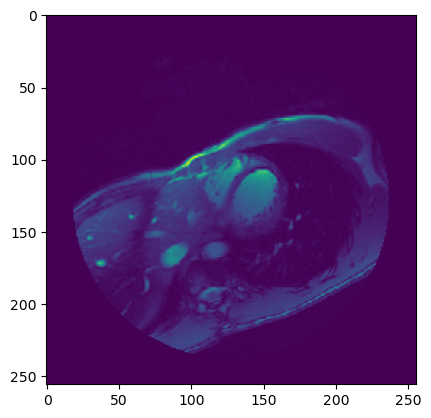

In [8]:
# print(Y_train[0][0])
plt.imshow(X_train[0])
plt.show()

In [9]:
kwargs = dict(
        rotation_range=180,
        zoom_range=0.5,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )

X_datagen = ImageDataGenerator(**kwargs)
Y_datagen = ImageDataGenerator(**kwargs)
val_X_datagen = ImageDataGenerator(**kwargs)
val_Y_datagen = ImageDataGenerator(**kwargs)


X_generator = X_datagen.flow(X_train, shuffle=False,
                                    batch_size=10, seed=seed)
Y_generator = Y_datagen.flow(Y_train, shuffle=False,
                                batch_size=10, seed=seed)
train_generator = zip(X_generator, Y_generator)

val_X_generator = val_X_datagen.flow(X_val, shuffle=False,
                                    batch_size=10, seed=seed)
val_Y_generator = val_Y_datagen.flow(Y_val, shuffle=False,
                                batch_size=10, seed=seed)
val_generator = zip(val_X_generator, val_Y_generator)

# Metricas

In [10]:
def dice_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth))
    return dice

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
    return dice

def dice_mon(smooth):
    def dicemon(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth=smooth)
    return dicemon

def jaccard_coef(y_true, y_pred, smooth=0.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return jaccard

def jaccard_mon(smooth):
    def jaccardmon(y_true, y_pred):
        return jaccard_coef(y_true, y_pred, smooth=smooth)
    return jaccardmon

# Modelando Unet

In [11]:
import tensorflow as tf
from keras.models import *
from keras.layers import *

tf.random.set_seed(seed)

In [12]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, 1, activation='sigmoid')(c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

# Configurando as metricas
smooth = K.epsilon()
dice_model = dice_loss(smooth)
dicemon = dice_mon(smooth)
jaccardmon = jaccard_mon(smooth)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])
# model.compile(optimizer = 'adam', loss = dice_model, metrics = [dicemon, 'accuracy', jaccardmon])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       dropout[0][0]                    
______________________________________________________________________________________________

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH + '.h5', verbose=1, save_weights_only=True)

callbacks = [checkpoint,
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_dicemon'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [32]:
results = model.fit(train_generator,steps_per_epoch=len(X_train)/10,epochs=100,callbacks=callbacks, validation_data=val_generator, validation_steps=len(X_val)/10)
json_model = model.to_json()
open(MODEL_PATH + '.json', 'w').write(json_model)
model.save_weights(MODEL_PATH + '.h5', overwrite=True)


Epoch 1/100
56/56 [==============================] - 36s 577ms/step - loss: 1.2651 - accuracy: 0.9689 - dicemon: 0.0180 - jaccardmon: 0.0090 - val_loss: 0.0934 - val_accuracy: 0.9736 - val_dicemon: 0.0622 - val_jaccardmon: 0.0282

Epoch 00001: val_loss improved from inf to 0.09337, saving model to logs\model_rede_hibrida.h5
Epoch 2/100
56/56 [==============================] - 28s 498ms/step - loss: 0.0793 - accuracy: 0.9780 - dicemon: 0.0717 - jaccardmon: 0.0328 - val_loss: 0.0816 - val_accuracy: 0.9770 - val_dicemon: 0.1069 - val_jaccardmon: 0.0526

Epoch 00002: val_loss improved from 0.09337 to 0.08160, saving model to logs\model_rede_hibrida.h5
Epoch 3/100
56/56 [==============================] - 28s 492ms/step - loss: 0.0690 - accuracy: 0.9788 - dicemon: 0.1063 - jaccardmon: 0.0473 - val_loss: 0.0545 - val_accuracy: 0.9742 - val_dicemon: 0.2723 - val_jaccardmon: 0.1354

Epoch 00003: val_loss improved from 0.08160 to 0.05447, saving model to logs\model_rede_hibrida.h5
Epoch 4/100
56


Epoch 00054: val_loss did not improve from 0.00830
Epoch 55/100
56/56 [==============================] - 28s 491ms/step - loss: 0.0088 - accuracy: 0.9951 - dicemon: 0.8656 - jaccardmon: 0.7049 - val_loss: 0.0103 - val_accuracy: 0.9944 - val_dicemon: 0.8617 - val_jaccardmon: 0.7157

Epoch 00055: val_loss did not improve from 0.00830
Epoch 56/100
56/56 [==============================] - 28s 492ms/step - loss: 0.0094 - accuracy: 0.9948 - dicemon: 0.8661 - jaccardmon: 0.7099 - val_loss: 0.0080 - val_accuracy: 0.9951 - val_dicemon: 0.8830 - val_jaccardmon: 0.7489

Epoch 00056: val_loss improved from 0.00830 to 0.00800, saving model to logs\model_rede_hibrida.h5
Epoch 57/100
56/56 [==============================] - 28s 492ms/step - loss: 0.0100 - accuracy: 0.9946 - dicemon: 0.8669 - jaccardmon: 0.7164 - val_loss: 0.0096 - val_accuracy: 0.9944 - val_dicemon: 0.8698 - val_jaccardmon: 0.7230

Epoch 00057: val_loss did not improve from 0.00800
Epoch 58/100
56/56 [==============================]

Epoch 83/100
56/56 [==============================] - 28s 491ms/step - loss: 0.0076 - accuracy: 0.9954 - dicemon: 0.8896 - jaccardmon: 0.7452 - val_loss: 0.0079 - val_accuracy: 0.9954 - val_dicemon: 0.8984 - val_jaccardmon: 0.7554

Epoch 00083: val_loss did not improve from 0.00679
Epoch 84/100
56/56 [==============================] - 28s 492ms/step - loss: 0.0092 - accuracy: 0.9950 - dicemon: 0.8686 - jaccardmon: 0.7171 - val_loss: 0.0070 - val_accuracy: 0.9958 - val_dicemon: 0.8786 - val_jaccardmon: 0.7272

Epoch 00084: val_loss did not improve from 0.00679
Epoch 85/100
56/56 [==============================] - 28s 491ms/step - loss: 0.0077 - accuracy: 0.9955 - dicemon: 0.8807 - jaccardmon: 0.7349 - val_loss: 0.0074 - val_accuracy: 0.9953 - val_dicemon: 0.9001 - val_jaccardmon: 0.7667

Epoch 00085: val_loss did not improve from 0.00679
Epoch 86/100
56/56 [==============================] - 28s 491ms/step - loss: 0.0083 - accuracy: 0.9951 - dicemon: 0.8791 - jaccardmon: 0.7272 - val_los

In [14]:
# Carregar modelo
model = model_from_json(open(MODEL_PATH + '.json').read())
model.load_weights(MODEL_PATH + '.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])

In [15]:
# print(results.history.keys())
model.evaluate(X_train, Y_train)

18/18 [==============================] - 46s 821ms/step - loss: 0.0055 - accuracy: 0.9978 - dicemon: 0.8879 - jaccardmon: 0.7435


[0.005484805908054113,
 0.997795581817627,
 0.8897669911384583,
 0.7460107207298279]

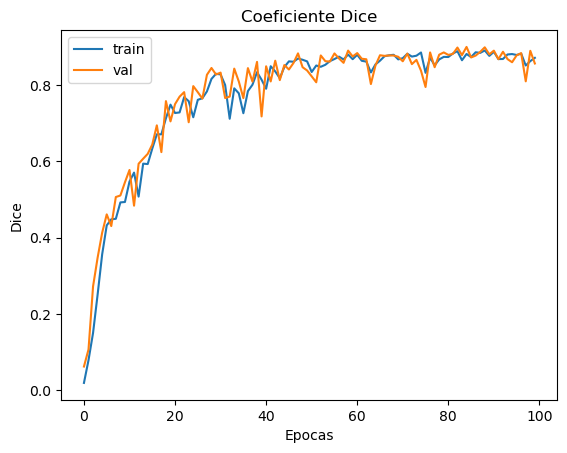

In [34]:
plt.plot(results.history['dicemon'])
plt.plot(results.history['val_dicemon'])
plt.title('Coeficiente Dice')

plt.ylabel('Dice')
plt.xlabel('Epocas')
# plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

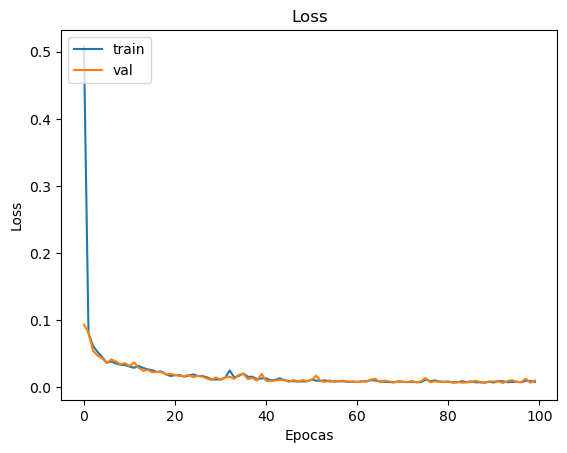

In [35]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss')

plt.ylabel('Loss')
plt.xlabel('Epocas')
# plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
predict_test = model.predict(X_test, verbose=1)
predict_test = np.where(predict_test>0.5, 1.0, 0.0)

6/6 [==============================] - 4s 598ms/step


indice =  83


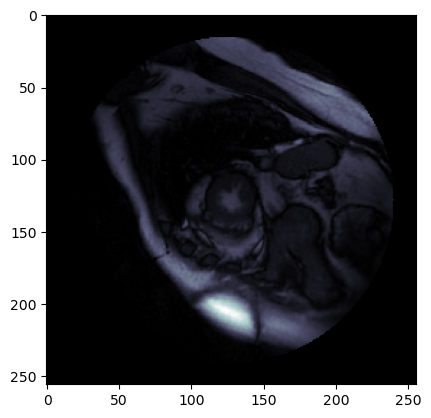

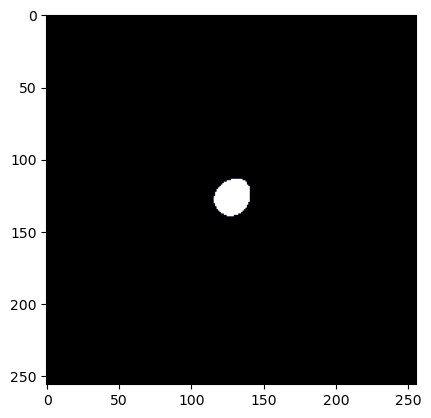

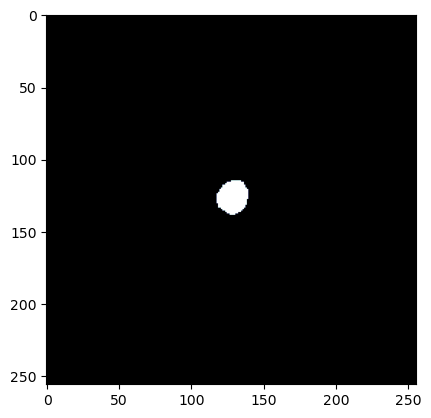

In [18]:
# Ver exemplos de imagens
exemplo = random.randint(0, 160)
print("indice = ", exemplo)

plt.imshow(X_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(predict_test[exemplo], cmap=plt.cm.bone)
plt.show()
# plt.imshow(chan_vese[exemplo], cmap=plt.cm.bone)
# plt.show()

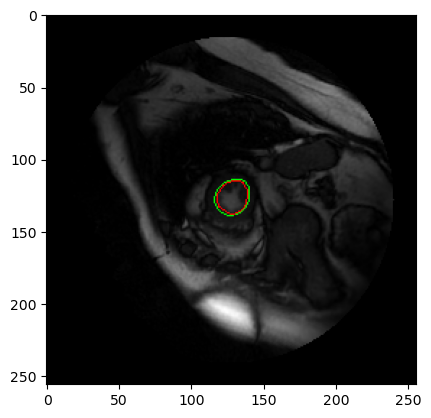

In [87]:
from skimage import img_as_ubyte 

def add_mascara(imagem, mascara, cor):
    img = imagem.copy()
    if np.ndim(img) == 2:
        img2 = np.empty((256, 256, 3), dtype=img.dtype)
        img2[:,:,:] = img[:,:, np.newaxis]
        img = img2
    
    mask = mascara.copy()
    if np.ndim(mask) == 3:
#         mask = cv2.cvtColor(mask.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
#         ret, bw_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        bw_mask = img_as_ubyte(mask)
    else:
        bw_mask = img_as_ubyte(mask)
        
    contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        ctrs = [len(ctr) for ctr in contours]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contours[max_ctr]])
        cv2.drawContours(img, np.array([pontos]),  0, cor, 1)

    return img
    

def marcar_ground_truth(ind, imagem, mascara):
    img1 = imagem[ind]
    img1 = np.squeeze(img1)
    img1 = img1.astype(int)
    img2 = mascara[ind]
    img3 = add_mascara(img1, img2, (0, 255, 0))

    return img3

def marcar_predict(ind, imagem, mascara):
    img1 = imagem
    img2 = np.squeeze(mascara[ind])
    img3 = add_mascara(img1, img2, (255, 0, 0))
    return img3

# dicom = X_test[exemplo]
# mascara_gt = Y_test[exemplo]
# mascara_p = predict_test[exemplo]

def marcar_segmentacao(ind, segmentacao):
    img = marcar_ground_truth(ind, X_test * 255, Y_test)
    img = marcar_predict(ind, img, segmentacao)
    return img

dicom2 = marcar_segmentacao(exemplo, predict_test)

# dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
# dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

In [149]:
from skimage.segmentation import morphological_chan_vese

def ctr_inicial(mascara):
    mask = mascara.copy()
    mask = img_as_ubyte(mask)
    
    contornos, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contornos) > 0:
        ctrs = [len(ctr) for ctr in contornos]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contornos[max_ctr]])
        return pontos
    
    return contornos
    
#     buildings = 1000
#     for contour in contornos:
#         # find center of each contour
#         M = cv2.moments(contour)
#         if M["m00"] != 0:
#             center_X = int(M["m10"] / M["m00"])
#             center_Y = int(M["m01"] / M["m00"])
#             contour_center = (center_X, center_Y)
#         else:
#             contour_center = (0, 0)
    
#         # calculate distance to image_center
#         distances_to_center = (distance.euclidean((128, 128), contour_center))
        
#         # save to a list of dictionaries
#         if distances_to_center < buildings:
#             retorno = contour

def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))

    return _store

def seg_chan_vese(scan, contorno_inicial, evolution):
    callback = store_evolution_in(evolution)
    ls = morphological_chan_vese(scan, iterations=100, init_level_set=contorno_inicial,
                             smoothing=3, iter_callback=callback)
    return ls.astype(np.float64)

def plot_seg_chan_vese(scan, chan_vese, evolution):
    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    ax = axes.flatten()
    
    ax[0].imshow(scan, cmap="gray")
    ax[0].set_axis_off()
    ax[0].contour(chan_vese, [0.5], colors='b')
    ax[0].set_title("Morphological GAC segmentation", fontsize=12)
    
    ax[1].imshow(chan_vese, cmap="gray")
    ax[1].set_axis_off()
    contour = ax[1].contour(evolution[0], [0.5], colors='r')
    contour.collections[0].set_label("Starting Contour")
    contour = ax[1].contour(evolution[5], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 5")
    contour = ax[1].contour(evolution[-1], [0.5], colors='b')
    contour.collections[0].set_label("Last Iteration")
    ax[1].legend(loc="upper right")
    title = "Morphological ACWE Curve evolution"
    ax[1].set_title(title, fontsize=12)
    plt.show()

37.013511046643494
30.675723300355934


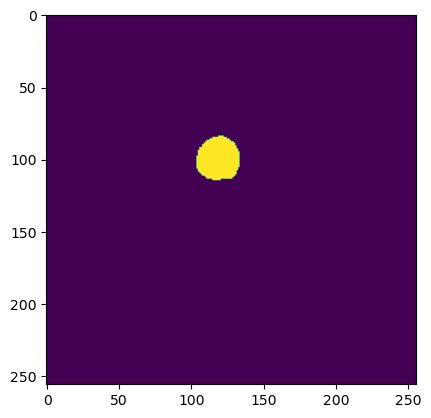

In [123]:
ci = ctr_inicial(np.squeeze(predict_test[94]))
mask_bit = np.empty((256, 256))
cv2.drawContours(mask_bit, np.array([ci]), 0, 255, cv2.FILLED)
mask_bit = np.where(mask_bit>128, 1.0, 0.0)

plt.imshow(mask_bit)
plt.show()

In [150]:
ci = []
chan_vese = []
evolution_cv = [[]] * len(X_test) 
print(X_test[0].shape)
for n, scan in tqdm(enumerate(X_test), total=len(X_test)):
    ci = ctr_inicial(np.squeeze(predict_test[n]))
    mask_bit = np.empty((256, 256))
    cv2.drawContours(mask_bit, np.array([ci]), 0, 255, cv2.FILLED)
    mask_bit = np.where(mask_bit>128, 1.0, 0.0)
    
    
    img1 = np.uint8(cv2.normalize(np.squeeze(scan), None, 0, 255, cv2.NORM_MINMAX))
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
    gimage = clahe.apply(img1) / 255
#     chan_vese.append(seg_chan_vese(np.squeeze(scan), np.squeeze(predict_test[n]), evolution_cv[n]))
    chan_vese.append(seg_chan_vese(gimage, mask_bit, evolution_cv[n]))
    

(256, 256, 1)


100%|██████████| 161/161 [03:28<00:00,  1.29s/it]


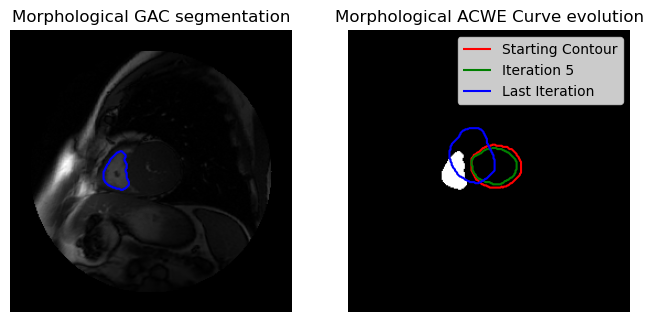

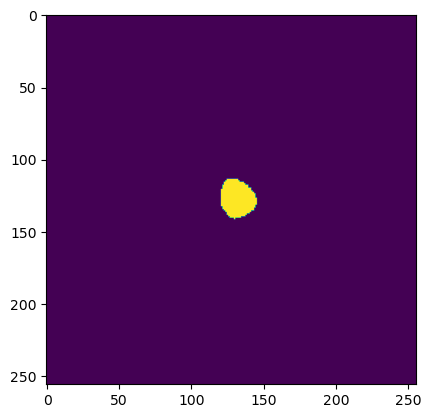

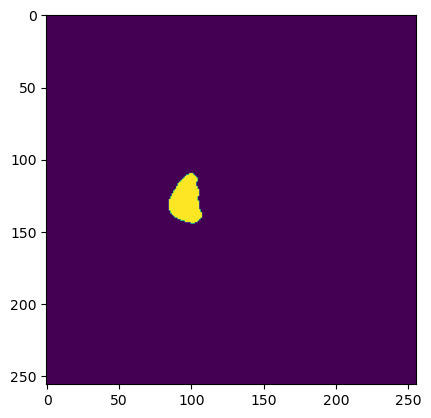

In [97]:
# plot_seg_snakes(X_test[exemplo], Y_test[exemplo], snakes[exemplo], predict_test[exemplo])

plot_seg_chan_vese(X_test[66], chan_vese[66], evolution_cv[66])

plt.imshow(np.squeeze(predict_test[66]))
plt.show()

plt.imshow(chan_vese[66])
plt.show()
# ct_snake = np.zeros((256, 256, 1), dtype="uint8")
# cv2.drawContours(ct_snake, [snakes[exemplo].astype(int)], 0, (255, 255, 255), cv2.FILLED)


# dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
# dicom2 = marcar_predict(exemplo, dicom2, predict_test)
# dicom2 = img3 = add_mascara(dicom2, ct_snake, (0, 0, 255))
# plt.imshow(dicom2)
# plt.show()

In [160]:
from sklearn import metrics


def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))


def mean_dice_coef(y_true, y_pred_bin):
    maior = 1
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    mean_dice_channel = 0.
    for i in range(batch_size):
        channel_dice = dice_coef(y_true[i, :, :], y_pred_bin[i, :, :])
        if channel_dice < maior and i != 94 and i != 14:
            maior = channel_dice
            indice = i
        mean_dice_channel += channel_dice/batch_size
    return mean_dice_channel, maior, indice


# def generate_metrics(title, y_pred_model):
#     cnf_matrix = metrics.confusion_matrix(Y_test, y_pred_model)
#     tn, fp = cnf_matrix[0] 
#     fn, tp = cnf_matrix[1]
#     print(title, "Metrics:")

#     print("Accuracy:",(tp+tn)/(tn+tp+fn+fp)) # (TP + TN)/(TOTAL)
#     print("Precision:",tp/(tp+fp)) # TP/(TP+FP)
#     print("Recall/Sensitivity:",tp/(tp+fn)) # TP/(TP+FN) 
#     print("Specificity:",tn/(tn+fp), "\n"); # TN/(TN + FP)

# generate_metrics("Decision tree", predict_test)
# generate_metrics("Logistic Regression", chan_vese)
print(Y_test.shape)
print(np.array(chan_vese).shape)
print(predict_test.shape)
mean_dice_coef(np.squeeze(Y_test), np.array(chan_vese))

(161, 256, 256, 1)
(161, 256, 256)
(161, 256, 256, 1)


(<tf.Tensor: shape=(), dtype=float64, numpy=0.7266075133448519>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0008605851979345956>,
 51)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


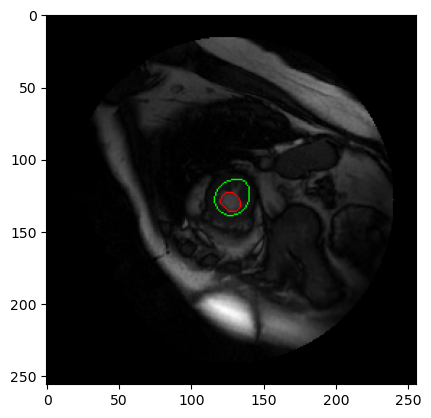

In [30]:
dicom2 = marcar_ground_truth(exemplo, X_test, Y_test) # Verde
dicom2 = marcar_predict(exemplo, dicom2, chan_vese) # Vermelho
plt.imshow(dicom2)
plt.show()

255
2.0


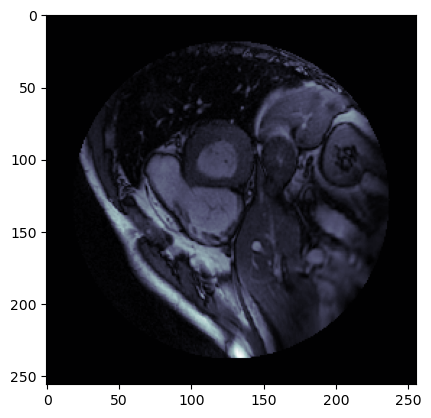

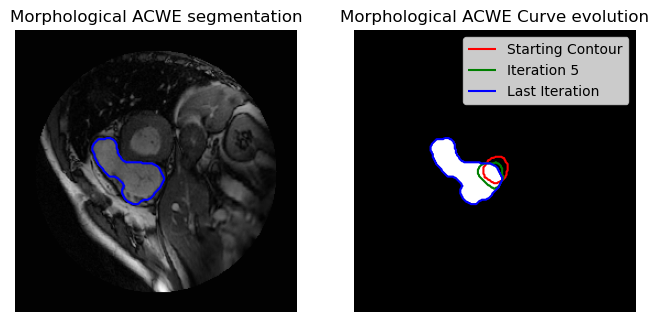

Chan vese


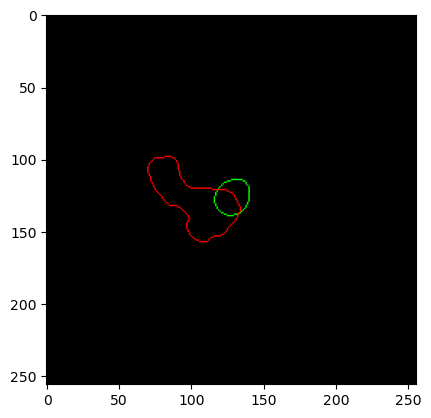

19.31063829787234
Resultado


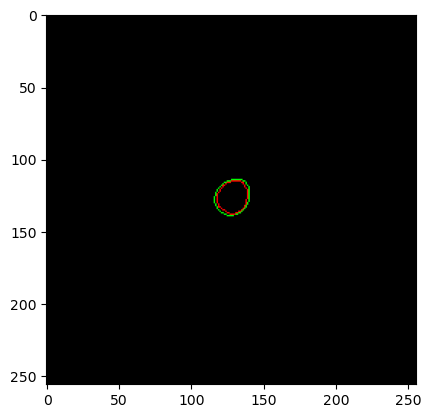

In [125]:
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient, morphological_chan_vese
from skimage import exposure

dicom_rgb = np.squeeze(X_test[94])
gimage = dicom_rgb

gimage = gimage * 255
gimage = gimage.astype(int)
print(np.max(gimage))

# gimage = inverse_gaussian_gradient(gimage)

# p2, p98 = np.percentile(gimage, (2, 98))
# gimage = exposure.rescale_intensity(gimage, in_range=(p2, p98))

img1 = np.uint8(cv2.normalize(gimage, None, 0, 255, cv2.NORM_MINMAX))
# clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(1,1))
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gimage = clahe.apply(img1) / 255

# gimage = exposure.equalize_adapthist(gimage, clip_limit=0.03)


ci = ctr_inicial(np.squeeze(predict_test[exemplo]))
mask_bit = np.empty((256, 256))
cv2.drawContours(mask_bit, np.array([ci]), 0, 255, cv2.FILLED)
mask_bit = np.where(mask_bit>128, 1.0, 0.0)

# mask_bit = np.squeeze(predict_test[exemplo])

plt.imshow(gimage, cmap=plt.cm.bone)
plt.show()

evolution = []
callback = store_evolution_in(evolution)

ls = morphological_chan_vese(gimage, iterations=100, init_level_set=mask_bit,
                             smoothing=3, iter_callback=callback)


fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(gimage, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='b')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='r')
contour.collections[0].set_label("Starting Contour")
contour = ax[1].contour(evolution[5], [0.5], colors='g')
contour.collections[0].set_label("Iteration 5")
contour = ax[1].contour(evolution[-1], [0.5], colors='b')
contour.collections[0].set_label("Last Iteration")
ax[1].legend(loc="upper right")
title = "Morphological ACWE Curve evolution"
ax[1].set_title(title, fontsize=12)

plt.show()

print("Chan vese")
dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = add_mascara(dicom2, ls, (255, 0, 0))
plt.imshow(dicom2)
plt.show()
print(single_dice_coef(Y_test[exemplo], ls))

print("Resultado")
dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

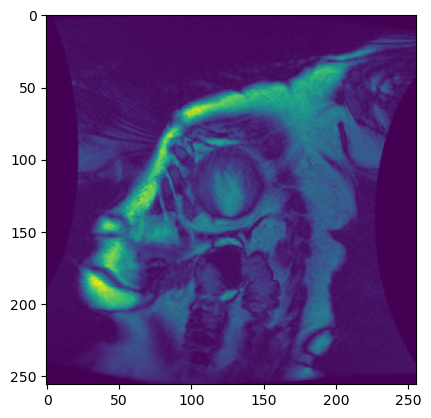

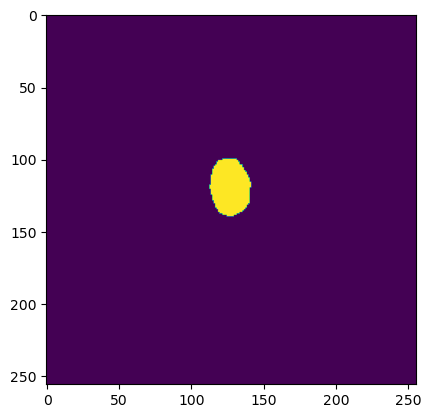

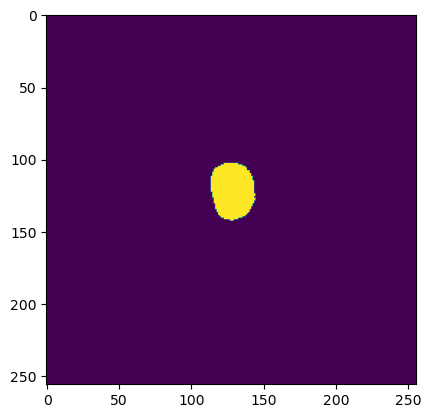

In [60]:
# dice_coef(Y_train[exemplo], ls)
plt.imshow(X_test[88])
plt.show()

plt.imshow(predict_test[88])
plt.show()

plt.imshow(Y_test[88])
plt.show()

# Figuras para monografia

In [181]:
import string
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols, figsize=(30,30))
#     ax.ravel()[0].imshow(X_test[exemplo_add], cmap=plt.cm.bone)
#     ax.ravel()[0].set_title('Scan')
#     ax.ravel()[0].set_axis_off()

    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title], cmap='gray')
#         ax.ravel()[ind].set_title(title)
#         ax.ravel()[ind].set_xlabel(f'({string.ascii_lowercase[ind]})')
        ax.ravel()[ind].set_xticks([])
        ax.ravel()[ind].set_yticks([])
#         ax.ravel()[ind].set_axis_off()
#         ind = ind + 1

    plt.tight_layout()
    plt.show()
#     extent = ax.get_window_extent().transformed(figure.dpi_scale_trans.inverted())
#     figure.savefig('Artigos/Monografia/EqualizacaoHist.png')
exemplo_add = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


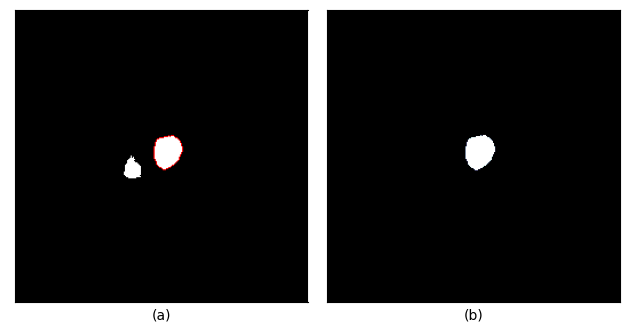

In [37]:
exemplo_add = 28

img = np.squeeze(predict_test[exemplo_add]).copy()
saida = np.empty((256, 256, 3), dtype=img.dtype)
saida[:,:,:] = img[:,:, np.newaxis]

bw_mask = img_as_ubyte(img)
mask_bit = np.zeros((256, 256))

contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if len(contours) > 0:
    ctrs = [len(ctr) for ctr in contours]
    max_ctr = np.argmax(ctrs)
    pontos = np.array([pt[0] for pt in contours[max_ctr]])
    cv2.drawContours(saida, np.array([pontos]), 0, (255,0,0), 1)
    cv2.drawContours(mask_bit, np.array([pontos]), 0, 255, cv2.FILLED)

imagens_da = {'Resultado Segmentação': saida,
              'Extração do Contorno': mask_bit}
    
display_multiple_img(imagens_da, 1, 2)

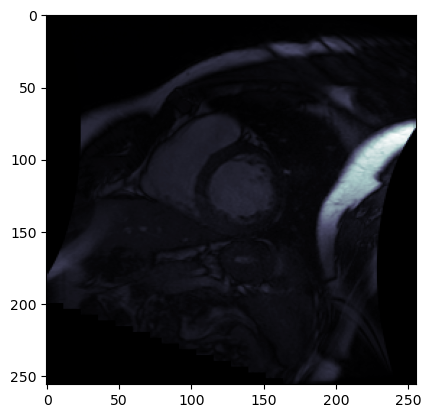

In [223]:
# x += 1
# print(x)
plt.imshow(X_test[56], cmap=plt.cm.bone)
plt.show()

In [ ]:
56 113

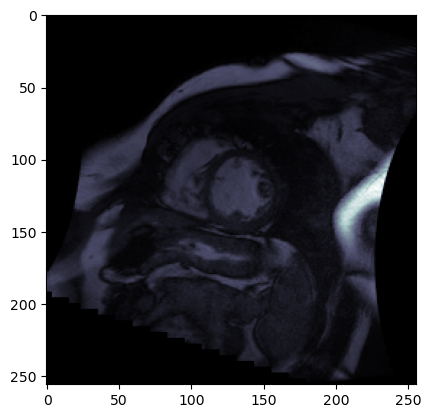

In [224]:
img1 = np.uint8(cv2.normalize(np.squeeze(X_test[113]), None, 0, 255, cv2.NORM_MINMAX))
clahe = cv2.createCLAHE(clipLimit=0.9, tileGridSize=(1,1))
gimage = clahe.apply(img1) / 255

plt.imshow(gimage, cmap=plt.cm.bone)
plt.show()

[38, 14, 39, 113, 19]
dict_keys(['Scan38', 'GT38', 'Mascara38', 'Segmentacao38', 'Scan14', 'GT14', 'Mascara14', 'Segmentacao14', 'Scan39', 'GT39', 'Mascara39', 'Segmentacao39', 'Scan113', 'GT113', 'Mascara113', 'Segmentacao113', 'Scan19', 'GT19', 'Mascara19', 'Segmentacao19'])


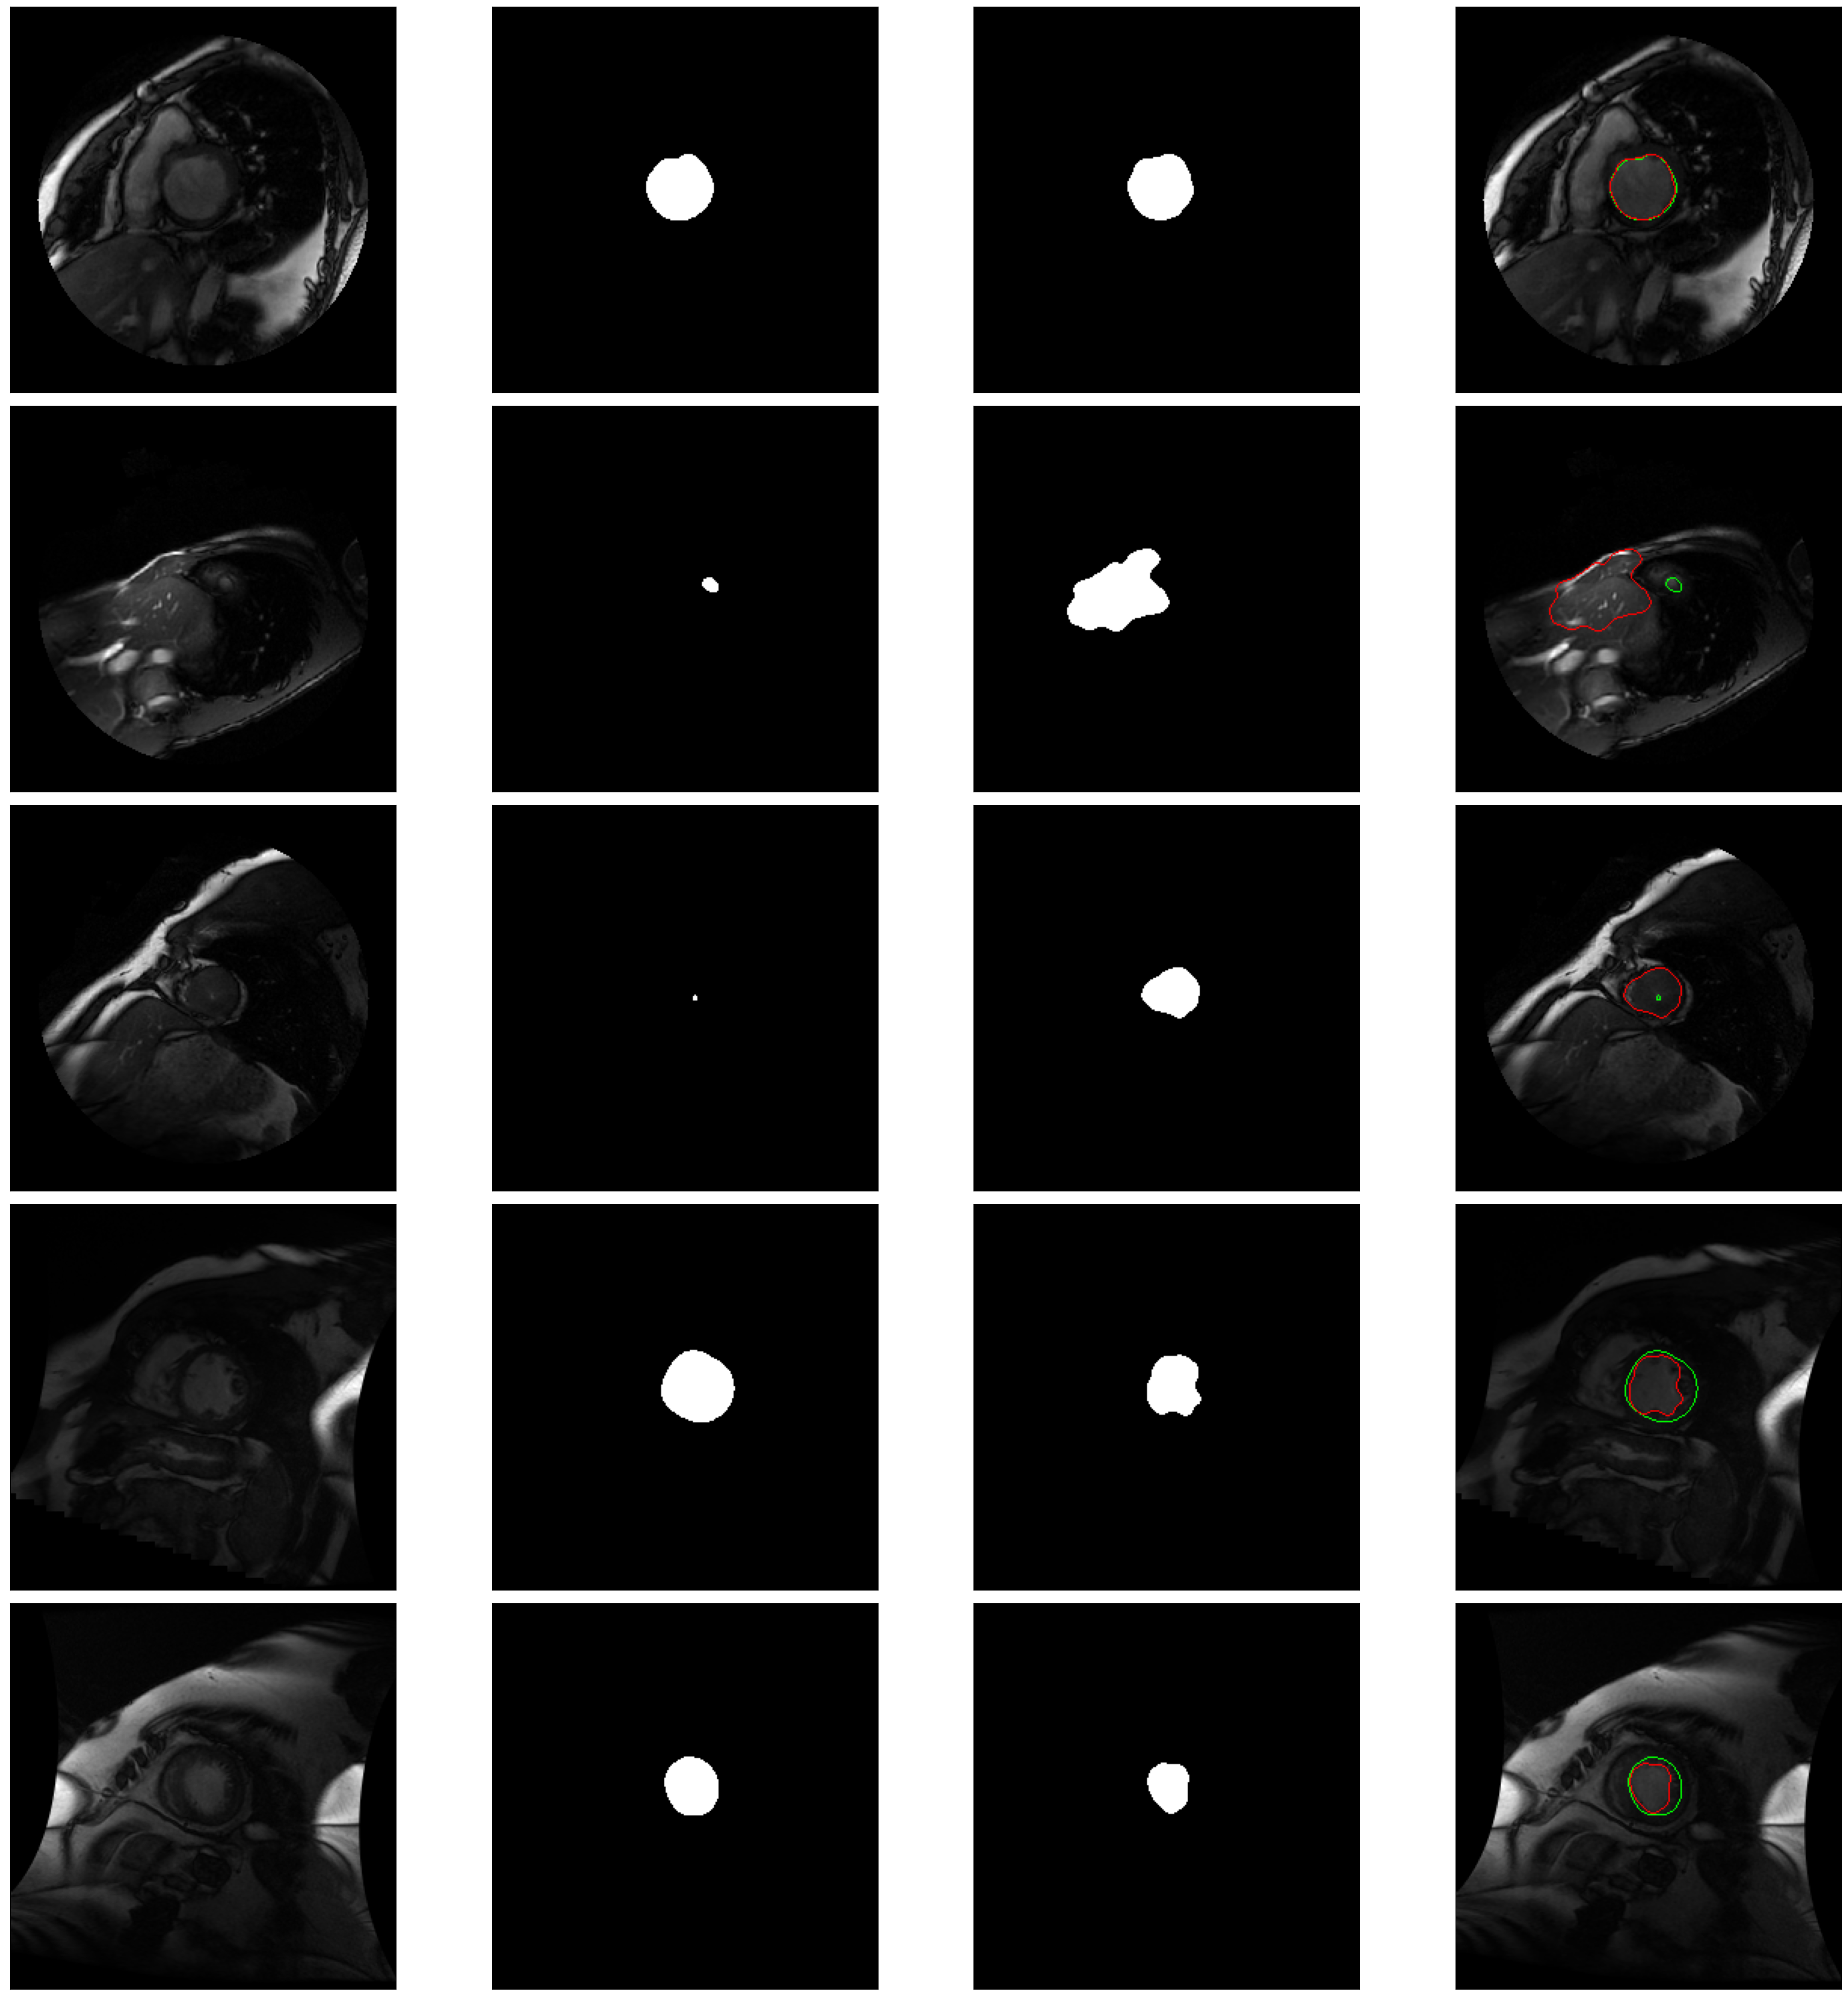

In [182]:
exemplos_mono = [38, 14, 39, random.randint(0,160), random.randint(0, 160)] #39 e testar 14

print(exemplos_mono)

imagens_da = {}
for ex in exemplos_mono:
    seg_final = marcar_segmentacao(ex, chan_vese)
    imagens_da['Scan' + str(ex)] = X_test[ex]
    imagens_da['GT' + str(ex)] = Y_test[ex]
    imagens_da['Mascara' + str(ex)] = chan_vese[ex]
    imagens_da['Segmentacao' + str(ex)] = seg_final.astype(int)
    

# imagens_da = {'Scan': X_test[exemplos_mono],
#               'b': chan_vese[exemplos_mono],
#               'c': seg_finais
#              }
print(imagens_da.keys())
display_multiple_img(imagens_da, 5, 4)

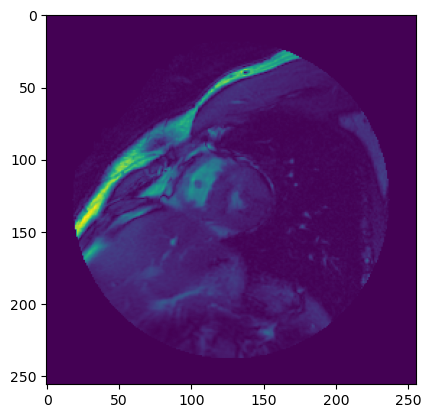

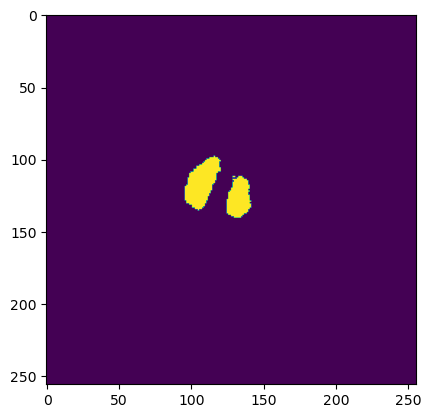

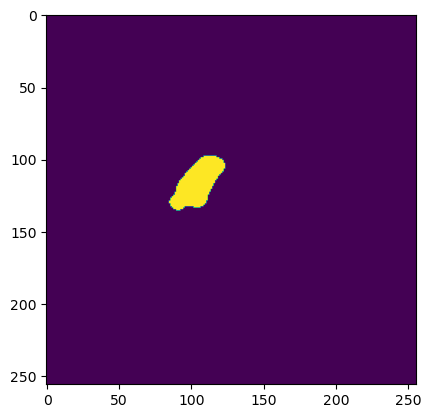

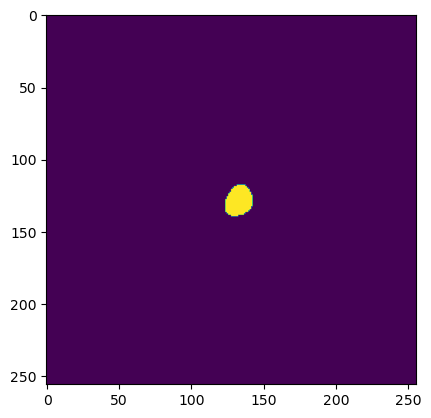

In [161]:
a = 51

plt.imshow(X_test[a])
plt.show()

plt.imshow(predict_test[a])
plt.show()

plt.imshow(chan_vese[a])
plt.show()

plt.imshow(Y_test[a])
plt.show()

37.013511046643494
30.675723300355934


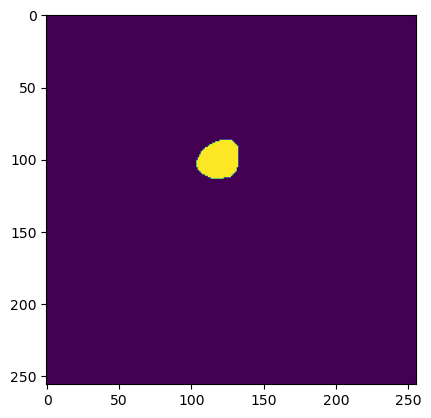

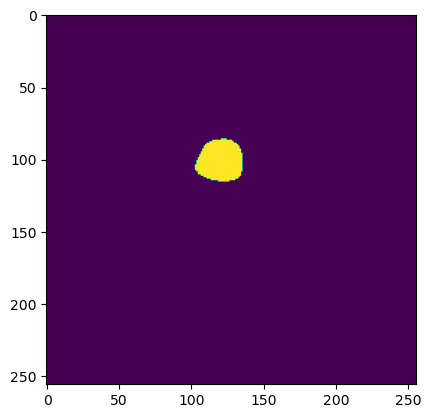

In [132]:
ci = ctr_inicial(np.squeeze(predict_test[94]))
mask_bit = np.empty((256, 256))
cv2.drawContours(mask_bit, np.array([ci]), 0, 255, cv2.FILLED)
mask_bit = np.where(mask_bit>128, 1.0, 0.0)

img1 = np.uint8(cv2.normalize(np.squeeze(X_test[94]), None, 0, 255, cv2.NORM_MINMAX))
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
gimage = clahe.apply(img1) / 255
#     chan_vese.append(seg_chan_vese(np.squeeze(scan), np.squeeze(predict_test[n]), evolution_cv[n]))
plt.imshow(seg_chan_vese(gimage, mask_bit, evolution_cv[94]))
plt.show()

plt.imshow(Y_test[94])
plt.show()